In [ ]:
force_recount = False
download_data = True

# gp45:
#input_fastq = "706-501_S6_L001.extendedFrags.fastq"
#output_fastq = "706-502_S18_L001.extendedFrags.fastq"
# HR2 surface display first try:
input_fastq = "49.extendedFrags.fastq"
output_fastq = "50.extendedFrags.fastq"
# HR2 bacterial two-hybrid first try:
#input_fastq = "FJH22.assembled.fastq"
#output_fastq = "FJH24.assembled.fastq"

# WT DNA sequences:
# gp45:
#wt = "ATGAAACTGTCTAAAGATACTACTGCTCTGCTTAAAAATTTCGCTACTATTAACTCTGGTATTATGCTTAA"\
#     "ATCCGGTCAATTTATTATGACTCGCGCAGTTAATGGTACAACTTATGCGGAAGCAAATATTTCTGACGTTA"\
#     "TTGATTTTGATGTAGCAATTTACGATTTGAACGGTTTTCTCGGTATTCTGTCTTTAGTTAATGATGATGCA"\
#     "GAAATTTCCCAGTCAGAAGATGGAAATATTAAAATTGCTGATGCCCGCTCAACAATTTTTTGGCCAGCAGC"\
#     "CGATCCGAGTACAGTAGTTGCTCCTAATAAACCAATTCCATTCCCGGTAGCATCTGCTGTTACTGAAATTA"\
#     "AAGCTGAAGACCTT"
# HR2:
wt = "GACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAA"\
     "GAATTTAAATGAATCTCTCATCGATCTCCAAGAACTT"

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install --upgrade cmdstanpy[all]
    !install_cmdstan


from os import path
import itertools as it
from textwrap import wrap
import numpy as np
from cmdstanpy import CmdStanModel
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.collections as collections

# establish possible mutations at each codon:
N = "ACGT"
S = "CG"
NNS = ["".join(i) for i in it.product(N, N, S)]
# create a dictionary for translating DNA to protein:
gencode = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W'}
aminoacids = "".join(np.unique(list(gencode.values())))

# translate the WT DNA sequence:
wt_translated = "".join([gencode[i] for i in wrap(wt, 3)])
print(wt_translated)

# for plotting when we want the amino acids in a biochemical order:
reorder = {
    20: 0, 10: 1, 13: 2, 1: 3, 0: 4, 18: 5, 11: 6, 4: 7, 15: 8, 2: 9,
    16: 10, 12: 11, 7: 12, 5: 13, 6: 14, 3: 15, 9: 16, 8: 17, 14: 18,
    19: 19, 17: 20
}
reorderf = [reorder[i] for i in range(21)]

NNS_sorted = [codon for _, codon in sorted(zip([": ".join([gencode[codon],
                                                           codon])
                                                for codon in NNS], NNS))]

     |████████████████████████████████| 51kB 2.2MB/s 
     |████████████████████████████████| 184kB 7.7MB/s 
ERROR: fbprophet 0.6 has requirement cmdstanpy==0.4, but you'll have cmdstanpy 0.9.63 which is incompatible.
  Found existing installation: cmdstanpy 0.4.0
    Uninstalling cmdstanpy-0.4.0:
      Successfully uninstalled cmdstanpy-0.4.0
CmdStan version: 2.24.1
Install directory: /root/.cmdstanpy
Download successful, file: /tmp/tmphcg5lv5d
Unpacked download as cmdstan-2.24.1
Building cmdstan-2.24.1 binaries
Test model compilation
Installed cmdstan-2.24.1
deleting tmpfiles dir: /tmp/tmpzfm2rgw6
done
DISGINASVVNIQKEIDRLNEVAKNLNESLIDLQEL


In [ ]:
# the Stan model: 
modelcode = """
data {
  int<lower=1> num_variants;
  int<lower=1> num_redundant_sites; // including WT once
  int<lower=1> num_redundant_positions;
  int<lower=1> num_segments;
  int<lower=0> input_counts[num_variants];
  int<lower=0> output_counts[num_variants];
  int<lower=1> segment_lengths[num_segments];
  int<lower=0,upper=1> is_wt[num_segments];
}
parameters {
  simplex[num_variants] input_p;
  simplex[num_variants] output_p;
  vector[num_redundant_sites] mu;
  vector<lower=0>[num_redundant_sites] sigma; // between-codon variation
}
transformed parameters {
  vector[num_variants] log_enrichment;
  vector[num_redundant_positions] log_enrichment_centered;
  log_enrichment = log(output_p ./ input_p);
  {
    int pos;
    int variant;
    int redundant_pos;
    pos = 1;
    variant = 1;
    redundant_pos = 1;
    for (seg in 1:num_segments) {
      if (is_wt[seg]) {
        log_enrichment_centered[redundant_pos:redundant_pos +
                                segment_lengths[seg]] =
          (log_enrichment[pos:pos + segment_lengths[seg]] -
           mu[num_redundant_sites]) / sigma[num_redundant_sites];
        pos += segment_lengths[seg];
        redundant_pos += segment_lengths[seg];
      }
      else if (segment_lengths[seg] != 1) {
        log_enrichment_centered[redundant_pos:redundant_pos +
                                segment_lengths[seg]] =
          (log_enrichment[pos:pos + segment_lengths[seg]] -
           mu[variant]) / sigma[variant];
        variant += 1;
        pos += segment_lengths[seg];
        redundant_pos += segment_lengths[seg];
      }
      else {
        pos += 1;
      }
    }
  }
}
model {
  int pos;
  int variant;
  input_counts ~ multinomial(input_p);
  output_counts ~ multinomial(output_p);
  log_enrichment_centered ~ normal(0, 1);
  sigma ~ exponential(10);
}
"""

filename = "aa-model.stan"
with open(filename, 'w') as f:
    f.write(modelcode)
model = CmdStanModel(stan_file = filename)

INFO:cmdstanpy:compiling stan program, exe file: /content/aa-model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/aa-model


In [ ]:
input_counts_npy = input_fastq.split('.')[0] + "_counts.npy"
output_counts_npy = output_fastq.split('.')[0] + "_counts.npy"
wt_input_counts_npy = input_fastq.split('.')[0] + "_wt-counts.npy"
wt_output_counts_npy = output_fastq.split('.')[0] + "_wt-counts.npy"

if download_data:
    from urllib.request import urlretrieve
    if input_fastq == "49.extendedFrags.fastq" and \
            output_fastq == "50.extendedFrags.fastq":
        if force_recount:
            # download fastqs
            urlretrieve("https://www.dropbox.com/s/7ibr5s9358rrxms/49.extended"\
                        "Frags.fastq?dl=1", filename = "49.extendedFrags.fastq")
            urlretrieve("https://www.dropbox.com/s/9xc6ytk6l7ftaza/50.extended"\
                        "Frags.fastq?dl=1", filename = "50.extendedFrags.fastq")
        else:
            # download npys
            urlretrieve("https://www.dropbox.com/s/3nawsu0yqhay7a5/49_counts.n"\
                        "py?dl=1", filename = "49_counts.npy")
            urlretrieve("https://www.dropbox.com/s/2wixy8bt356s0us/50_counts.n"\
                        "py?dl=1", filename = "50_counts.npy")
            urlretrieve("https://www.dropbox.com/s/vca4bo6rauv6of9/49_wt-count"\
                        "s.npy?dl=1", filename = "49_wt-counts.npy")
            urlretrieve("https://www.dropbox.com/s/9438hmhyr3qvvu9/50_wt-count"\
                        "s.npy?dl=1", filename = "50_wt-counts.npy")
    elif input_fastq == "FJH22.assembled.fastq" and \
            output_fastq == "FJH24.assembled.fastq":
        if force_recount:
            urlretrieve("https://www.dropbox.com/s/mv1iwkb1rt80qzi/FJH22.assem"\
                        "bled.fastq?dl=1", filename = "FJH22.assembled.fastq")
            urlretrieve("https://www.dropbox.com/s/r8nkauzirir2kz8/FJH24.assem"\
                        "bled.fastq?dl=1", filename = "FJH24.assembled.fastq")
        else:
            urlretrieve("https://www.dropbox.com/s/17pr81l3z5hqt3f/FJH22_count"\
                        "s.npy?dl=1", filename = "FJH22_counts.npy")
            urlretrieve("https://www.dropbox.com/s/49vkng0913q0i4h/FJH24_count"\
                        "s.npy?dl=1", filename = "FJH24_counts.npy")
            urlretrieve("https://www.dropbox.com/s/3tqu2fmcc5uqd3d/FJH22_wt-co"\
                        "unts.npy?dl=1", filename = "FJH22_wt-counts.npy")
            urlretrieve("https://www.dropbox.com/s/jaze68ppy2kewes/FJH24_wt-co"\
                        "unts.npy?dl=1", filename = "FJH24_wt-counts.npy")
    elif input_fastq == "706-501_S6_L001.extendedFrags.fastq" and \
            output_fastq == "706-502_S18_L001.extendedFrags.fastq":
        if force_recount:
            urlretrieve("https://www.dropbox.com/s/0e5civ4b8kvj18i/706-501_S6_"\
                        "L001.extendedFrags.fastq?dl=1",
                        filename = "706-501_S6_L001.extendedFrags.fastq")
            urlretrieve("https://www.dropbox.com/s/ig6fqk8fgj0z202/706-502_S18"\
                        "_L001.extendedFrags.fastq?dl=1",
                        filename = "706-502_S18_L001.extendedFrags.fastq")
        else:
            urlretrieve("https://www.dropbox.com/s/9wszcfn46ucdp6k/706-501_S6_"\
                        "L001_counts.npy?dl=1",
                        filename = "706-501_S6_L001_counts.npy")
            urlretrieve("https://www.dropbox.com/s/ey83g8smh19rez6/706-502_S18"\
                        "_L001_counts.npy?dl=1",
                        filename = "706-502_S18_L001_counts.npy")
            urlretrieve("https://www.dropbox.com/s/f33fpsig4cqg1wj/706-501_S6_"\
                        "L001_wt-counts.npy?dl=1",
                        filename = "706-501_S6_L001_counts.npy")
            urlretrieve("https://www.dropbox.com/s/eznr5lilu09jn2n/706-502_S18"\
                        "_L001_wt-counts.npy?dl=1",
                        filename = "706-502_S18_L001_counts.npy")
    else:
        print("the desired fastq pair is not available via this Dropbox")

In [ ]:
if path.exists(input_counts_npy) and path.exists(wt_input_counts_npy) and \
        not force_recount:
    input_counts = np.load(input_counts_npy)
    wt_input_counts = np.load(wt_input_counts_npy)
    count_input = False
else:
    input_counts = np.zeros((len(NNS), len(wt_translated)), dtype = int)
    count_input = True
    
if path.exists(output_counts_npy) and path.exists(wt_output_counts_npy) and \
        not force_recount:
    output_counts = np.load(output_counts_npy)
    wt_output_counts = np.load(wt_output_counts_npy)
    count_output = False
else:
    output_counts = np.zeros((len(NNS), len(wt_translated)), dtype = int)
    count_output = True
    
    
if count_input or count_output:
    from subprocess import check_call, Popen, PIPE

    # count mutants
    for pos in range(len(wt_translated)):
        for i, codon in enumerate(NNS_sorted):
            if codon != wt[3 * pos: 3 * pos + 3]:
                # create the expected mutant sequence,
                # then use grep -c to count it in the reads
                seq = wt[:3 * pos] + codon + wt[3 * pos + 3:]
                
                if count_input:
                    p = Popen(["grep", "-c", seq, input_fastq], stdout = PIPE)
                    out = p.communicate()[0]
                    rc = p.returncode
                    if rc == 0:
                        input_counts[i, pos] = int(out)
                    elif rc > 1:
                        print("grep for input counts exited with code " + \
                              str(rc))
                    
                if count_output:
                    p = Popen(["grep", "-c", seq, output_fastq], stdout = PIPE)
                    out = p.communicate()[0]
                    rc = p.returncode
                    if rc == 0:
                        output_counts[i, pos] = int(out)
                    elif rc > 1:
                        print("grep for output counts exited with code " + \
                              str(rc))
            else:
                if count_input:
                    input_counts[i, pos] = -1 # use -1 as a placeholder for WT
                if count_output:
                    output_counts[i, pos] = -1
    
    # now count wild-type
    if count_input:
        p = Popen(["grep", "-c", wt, input_fastq], stdout = PIPE)
        out = p.communicate()[0]
        rc = p.returncode
        if rc == 0:
            wt_input_counts = int(out)
        elif rc > 1:
            print("grep for input WT counts exited with code " + str(rc))
        np.save(input_counts_npy, input_counts, allow_pickle = False)
        np.save(wt_input_counts_npy, wt_input_counts, allow_pickle = False)
    if count_output:
        p = Popen(["grep", "-c", wt, output_fastq], stdout = PIPE)
        out = p.communicate()[0]
        rc = p.returncode
        if rc == 0:
            wt_output_counts = int(out)
        elif rc > 1:
            print("grep for output WT counts exited with code " + str(rc))
        np.save(output_counts_npy, output_counts, allow_pickle = False)
        np.save(wt_output_counts_npy, wt_output_counts, allow_pickle = False)

In [ ]:
input_counts_1d = input_counts.flatten('F')[input_counts.flatten('F') != -1]
output_counts_1d = output_counts.flatten('F')[output_counts.flatten('F') != -1]
# last element is WT count
input_counts_1d = np.append(input_counts_1d, wt_input_counts)
output_counts_1d = np.append(output_counts_1d, wt_output_counts)


last_codon = "AAA"
run_length = 0
segment_lengths = []
is_wt = []
num_redundant_sites = 1 # +1 for WT
for pos in range(len(wt_translated)):
    for i, codon in enumerate(NNS_sorted):
        if codon != wt[3 * pos: 3 * pos + 3]:
            if gencode[codon] == gencode[last_codon] or run_length == 0:
                run_length += 1
            else:
                segment_lengths.append(run_length)
                run_length = 1
            last_codon = codon
            if run_length == 1:
                if gencode[codon] == wt_translated[pos]:
                    is_wt.append(1)
                else:
                    is_wt.append(0)
            if run_length == 2 and gencode[codon] != wt_translated[pos]:
                num_redundant_sites += 1
segment_lengths.append(run_length)

num_redundant_positions = int(np.sum(np.array(segment_lengths)\
                                     [np.array(segment_lengths) != 1]) + \
                              sum(is_wt) - \
                              np.sum((np.array(segment_lengths) != 1) & \
                                     (np.array(is_wt))) + 1)

data = {"num_variants": len(input_counts_1d),
        "num_redundant_sites": num_redundant_sites,
        "num_redundant_positions": num_redundant_positions,
        "num_segments": len(segment_lengths),
        "input_counts": input_counts_1d,
        "output_counts": output_counts_1d,
        "segment_lengths": segment_lengths,
        "is_wt": is_wt}


fit = model.sample(data, adapt_delta = 0.95)
summary = fit.summary()
print(max(summary["R_hat"])) # check if parameter samples have converged
print(min(summary["N_Eff"])) # see if we have enough effective samples for quant
summary

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


1.00155
184.0


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-276092.00000,1.160610,39.944200,-276159.00000,-276091.00000,-276028.00000,1184.5,0.543697,1.00155
input_p[1],0.00055,0.000003,0.000150,0.00032,0.00054,0.00081,2437.0,1.100000,1.00000
input_p[2],0.00034,0.000002,0.000110,0.00019,0.00033,0.00054,3688.0,1.700000,1.00000
input_p[3],0.00024,0.000001,0.000089,0.00012,0.00023,0.00040,4428.0,2.000000,1.00000
input_p[4],0.00021,0.000001,0.000094,0.00008,0.00019,0.00038,7544.0,3.500000,1.00000
...,...,...,...,...,...,...,...,...,...
log_enrichment_centered[689],0.02600,0.018000,0.970000,-1.60000,0.04500,1.60000,2791.0,1.300000,1.00000
log_enrichment_centered[690],0.02900,0.020000,0.980000,-1.60000,0.02400,1.60000,2341.0,1.100000,1.00000
log_enrichment_centered[691],0.16000,0.023000,0.970000,-1.50000,0.16000,1.70000,1785.0,0.820000,1.00000


In [ ]:
fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpisenzcdd/aa-model-202009022158-1-mk9ndfxw.csv, /tmp/tmpisenzcdd/aa-model-202009022158-2-zj13sxwb.csv, /tmp/tmpisenzcdd/aa-model-202009022158-3-tcg76dvl.csv, /tmp/tmpisenzcdd/aa-model-202009022158-4-o4yzznsp.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
131 of 4000 (3.3%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmpisenzcdd/aa-model-202009022158-1-mk9ndfxw.csv, /tmp/tmpisenzcdd/aa-model-202009022158-2-zj13sxwb.csv, /tmp/tmpisenzcdd/aa-model-202009022158-3-tcg76dvl.csv, /tmp/tmpisenzcdd/aa-model-202009022158-4-o4yzznsp.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n131 of 4000 (3.3%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [ ]:
# we will grab just the log enrichments from the array of sampled values,
# and collapse from (samples, chains, parameters) to (samples, parameters)
mu_samples = fit.sample[:,:,fit.column_names.index("mu.1"):\
                        fit.column_names.index("mu." + \
                                               str(num_redundant_sites))]\
                 .reshape(-1, num_redundant_sites - 1)
loge_samples = fit.sample[:,:,fit.column_names.index("log_enrichment.1"):\
                          fit.column_names.index("log_enrichment." + \
                                                 str(len(input_counts_1d)))]\
                 .reshape(-1, len(input_counts_1d) - 1)
wt_mu_samples = fit.sample[:,:,
                           fit.column_names.index("mu." + \
                                                  str(num_redundant_sites))]\
                                                  .flatten()
relative_mu_samples = mu_samples - wt_mu_samples[:, np.newaxis]
relative_loge_samples = loge_samples - wt_mu_samples[:, np.newaxis]

print(np.quantile(wt_mu_samples, 0.05))
print(np.quantile(wt_mu_samples, 0.95))

print(wt_input_counts)
print(wt_output_counts)

quantile5_relative_mu_1d = np.quantile(relative_mu_samples, 0.05, axis = 0)
quantile95_relative_mu_1d = np.quantile(relative_mu_samples, 0.95, axis = 0)
quantile5_relative_loge_1d = np.quantile(relative_loge_samples, 0.05, axis = 0)
quantile95_relative_loge_1d = np.quantile(relative_loge_samples, 0.95, axis = 0)

# Now we have to go back and put these into the 2D array including WT positions
quantile5_relative_mu_2d = np.empty((len(aminoacids), len(wt_translated)))
quantile95_relative_mu_2d = np.empty((len(aminoacids), len(wt_translated)))

j = 0
k = 0
l = 0            
for pos in range(len(wt_translated)):
    for i in range(len(aminoacids)):
        if not (sum([gencode[codon] == wt_translated[pos]
                     for codon in NNS_sorted]) == 1 and \
                wt_translated[pos] == aminoacids[i] and \
                wt[3 * pos: 3 * pos + 3] in NNS_sorted):
            if is_wt[l]:
                quantile5_relative_mu_2d[i, pos] = np.nan
                quantile95_relative_mu_2d[i, pos] = np.nan
                k += segment_lengths[l]
            elif segment_lengths[l] > 1:
                quantile5_relative_mu_2d[i, pos] = quantile5_relative_mu_1d[j]
                quantile95_relative_mu_2d[i, pos] = quantile95_relative_mu_1d[j]
                j += 1
                k += segment_lengths[l]
            else:
                quantile5_relative_mu_2d[i, pos] = quantile5_relative_loge_1d[k]
                quantile95_relative_mu_2d[i, pos] = \
                    quantile95_relative_loge_1d[k]
                k += 1
            l += 1
        else:
            quantile5_relative_mu_2d[i, pos] = np.nan
            quantile95_relative_mu_2d[i, pos] = np.nan

# We could also mask out the positions we have little information about:
quantile5_relative_mu_2d_masked = \
    np.ma.masked_where((quantile5_relative_mu_2d < -1) & \
                       (quantile95_relative_mu_2d > 1),
                       quantile5_relative_mu_2d)
quantile95_relative_mu_2d_masked = \
    np.ma.masked_where((quantile5_relative_mu_2d < -1) & \
                       (quantile95_relative_mu_2d > 1),
                       quantile95_relative_mu_2d)

-0.36230695
0.49591895
4573
2939


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


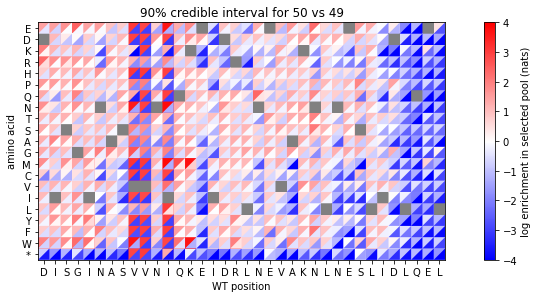

In [ ]:
# plotting method adapted from:
# https://stackoverflow.com/questions/44291155

mpl.rcParams['path.simplify_threshold'] = 0.0

cmap = mpl.cm.get_cmap('bwr')
cmap.set_bad(color = 'gray')

def triatpos(pos=(0,0), rot=0):
    r = np.array([[-1,-1],[1,-1],[1,1],[-1,-1]])*.5
    rm = [[np.cos(np.deg2rad(rot)), -np.sin(np.deg2rad(rot))],
          [np.sin(np.deg2rad(rot)), np.cos(np.deg2rad(rot))]]
    r = np.dot(rm, r.T).T
    r[:,0] += pos[0]
    r[:,1] += pos[1]
    return r

def triamatrix(a, ax, rot=0, cmap=plt.cm.bwr, vmin=-1, vmax=1, **kwargs):
    segs = []
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            segs.append(triatpos((j,i), rot=rot) )
    col = collections.PolyCollection(segs, cmap=cmap, **kwargs)
    col.set_array(np.ma.masked_invalid(a.flatten()))
    col.set_clim(vmin, vmax)
    ax.add_collection(col)
    return col

bound = 4

fig, ax = plt.subplots(figsize = (11, 4.25))
im1 = ax.imshow(quantile95_relative_mu_2d[reorderf, :], cmap = cmap,
                vmin = -bound, vmax = bound, rasterized = False)
im2 = triamatrix(quantile5_relative_mu_2d[reorderf, :], ax, rot = 90,
                 cmap = cmap, vmin = -bound, vmax = bound, rasterized = False)

fig.colorbar(im1, ax = ax, label = "log enrichment in selected pool (nats)")

plt.yticks(np.arange(len(aminoacids)), [aminoacids[i] for i in reorderf])
plt.xticks(np.arange(len(wt_translated)), wt_translated)
plt.ylabel("amino acid")
plt.xlabel("WT position")
plt.title("90% credible interval for " + output_fastq.split('.')[0] + " vs " + \
          input_fastq.split('.')[0])

plt.tight_layout()
plt.savefig("90-percent-CI_AA.pdf", dpi = 1200)
plt.show()

Text(0, 0.5, 'probability mass')

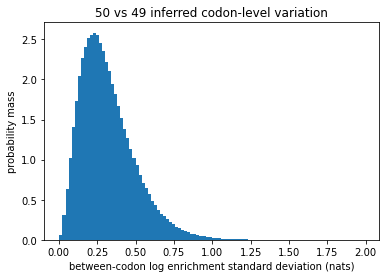

In [ ]:
plt.hist(fit.sample[:,:,fit.column_names.index("sigma.1"):\
                    fit.column_names.index("sigma." + \
                                           str(num_redundant_sites))]\
             .reshape(-1, num_redundant_sites - 1).flatten(),
         bins = 100, density = True)
plt.title(output_fastq.split('.')[0] + " vs " + input_fastq.split('.')[0] + \
          " inferred codon-level variation")
plt.xlabel("between-codon log enrichment standard deviation (nats)")
plt.ylabel("probability mass")

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


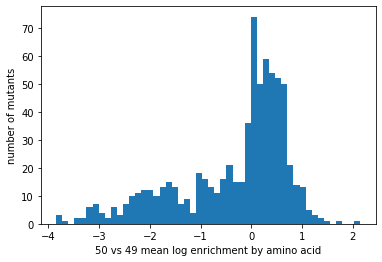

In [ ]:
mean_relative_mu_1d = np.mean(relative_mu_samples, axis = 0)
mean_relative_loge_1d = np.mean(relative_loge_samples, axis = 0)

mean_relative_mu_2d = np.empty((len(aminoacids), len(wt_translated)))

j = 0
k = 0
l = 0            
for pos in range(len(wt_translated)):
    for i in range(len(aminoacids)):
        if not (sum([gencode[codon] == wt_translated[pos]
                     for codon in NNS_sorted]) == 1 and \
                wt_translated[pos] == aminoacids[i] and \
                wt[3 * pos: 3 * pos + 3] in NNS_sorted):
            if is_wt[l]:
                mean_relative_mu_2d[i, pos] = np.nan
                k += segment_lengths[l]
            elif segment_lengths[l] > 1:
                mean_relative_mu_2d[i, pos] = mean_relative_mu_1d[j]
                j += 1
                k += segment_lengths[l]
            else:
                mean_relative_mu_2d[i, pos] = mean_relative_loge_1d[k]
                k += 1
            l += 1
        else:
            mean_relative_mu_2d[i, pos] = np.nan
            
            
plt.hist(mean_relative_mu_2d.flatten(), bins = 50)
plt.xlabel(output_fastq.split('.')[0] + " vs " + input_fastq.split('.')[0] + \
           " mean log enrichment by amino acid")
plt.ylabel("number of mutants")
plt.savefig("histogram_AA.pdf")
plt.show()

#np.save("mean.npy", mean_relative_mu_2d, allow_pickle = False)

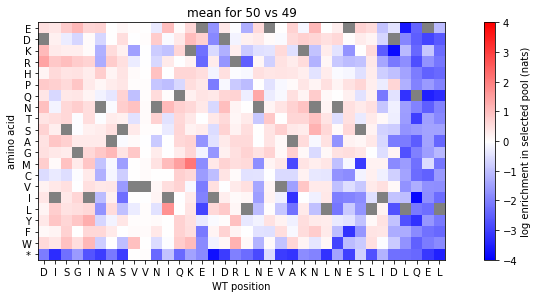

In [ ]:
fig, ax = plt.subplots(figsize = (11, 4.25))
plt.imshow(mean_relative_mu_2d[reorderf, :], cmap = cmap,
           vmin = -bound, vmax = bound, rasterized = False)

fig.colorbar(im1, ax = ax, label = "log enrichment in selected pool (nats)")

plt.yticks(np.arange(len(aminoacids)), [aminoacids[i] for i in reorderf])
plt.xticks(np.arange(len(wt_translated)), wt_translated)
plt.ylabel("amino acid")
plt.xlabel("WT position")
plt.title("mean for " + output_fastq.split('.')[0] + " vs " + \
          input_fastq.split('.')[0])

plt.tight_layout()
plt.savefig("mean_AA.pdf", dpi = 1200)
plt.show()